List of kernels I like and took inspiration from(and copied from):
- [Analysing CTDS show- Views and Reach](https://www.kaggle.com/kurianbenoy/analysing-ctds-show-views-and-reach)
- [Generating Data from the Chai](https://www.kaggle.com/muellerzr/generating-data-from-the-chai)

Thanks for hosting this dataset!

<div class=h3> Summary</div>
In this kernel,

- I've attempted to generate some features out of the subtitle data available in csv format
- aggregated the csvs together for an easier more database-like analysis
- a bit of speaker related metrics exploration
- attempted to identify bad data

NLP analysis done is very primitive and not using any particular model or toolkit.

Let's begin by importing the necessary data and helper functions. Some of the libaries imported are unused(WIP). 

## 1. Importing Libraries  and loading data

In [ ]:
!pip install chart_studio --quiet

In [ ]:
import pandas as pd
import os
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
import chart_studio.plotly as py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cufflinks as cf
from sklearn.cluster import KMeans
import tensorflow_hub as hub
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

from plotly.offline import iplot
pd.options.plotting.backend = "plotly"

In [ ]:
HARDCODE_LAST_SPEAK_DURATION = 40
BASE_PATH = "../input/chai-time-data-science/"
BASE_CSV_PATH = "../input/generating-cleaner-sublititles-file/"
df_episodes = pd.read_csv(BASE_PATH+"Episodes.csv")

In [ ]:
def merge_consecutive_data(df):
    """If same speaker content is in succession, merge it into a single row to make further analysis simpler"""
    new_idx = 0
    rows = []
    for idx,row in df.iterrows():
        if new_idx == 0:
            prev_row = row
            new_idx += 1
            continue
        if prev_row["Speaker"] == row["Speaker"]:
            prev_row["Text"] += row["Text"]
        else:
            rows.append(prev_row)
            prev_row = row
            prev_row["relative_index"] = new_idx
            new_idx += 1
        if idx == df.shape[0] - 1:
            rows.append(prev_row)
    df = pd.DataFrame(rows)
    return df

def get_time(t):
    """hh:mm:ss to seconds. Since time isn't formatted nicely in cleaned data, using hacks"""
    ts = t.split(":")
    total = 0
    for idx, data in enumerate(ts[::-1]):
        total += int(data) * 60**idx
    return total        

def calculate_speak_duration(df, df_episodes, episode_id):
    """Calculate speaker duration in seconds and also in time elapsed since 0"""
    df = df.reset_index()
    df["duration"] = None
    df["timestamp_relative"] = None
    prev_time = None
    for idx, row in df.iterrows():
        if idx == 0:
            prev_time = get_time(row["Time"])
            df.loc[idx, "timestamp_relative"] = prev_time
            continue
        curr_time = get_time(row["Time"])
        df.loc[idx-1, "duration"] = curr_time - prev_time
        prev_time = curr_time
        df.loc[idx, "timestamp_relative"] = curr_time
    # Hardcoding because for some of the cases subtracting from episode duration is producing too large numbers than practically expected
#     df.loc[idx, "duration"] = df_episodes[df_episodes["episode_id"] == episode_id]["episode_duration"].values[0] - prev_time
    df.loc[idx, "duration"] = HARDCODE_LAST_SPEAK_DURATION
    return df

Now, we load all the csv from [this kernel's output](https://www.kaggle.com/tomtillo/generating-cleaner-sublititles-file). Original datasource can also be used for analysis. 
For simplicity in defining visualizations and analysis, I am explicitly skipping E69 which is a host-only special episode.

In [ ]:
df = pd.DataFrame()
for f in os.listdir(BASE_PATH+"Cleaned Subtitles"):
    if f == "E69.csv":
        continue
    df_e = pd.read_csv(BASE_PATH+'Cleaned Subtitles/'+f)
    
    df_e["relative_index"] = df_e.index
    df_e["episode_id"] = f.split(".csv")[0]
    df_e = merge_consecutive_data(df_e)
    df_e = calculate_speak_duration(df_e, df_episodes, f.split(".csv")[0])
    df = df.append(df_e)
del df["index"]

In [ ]:

print("Shape of all data:", df.shape)

In [ ]:
df.head(2)

Columns are as follows:
 - `relative_index`: Preserving the index of individual dataframe(0-max) per episode
 - `timestamp_relative`: It's a conversion of `Time` column in seconds
 - `duration`: Duration for which a speaker spoke
 
 Let's add word and sentence level data to the dataframe.

In [ ]:
def get_words_list(x):
    """For an input text, returns list of words used"""
    x_list = x.replace(".", " ").replace(",", " ").lower().split()
    return x_list

def get_num_words(x):
    """For an input text, returns number of words used"""
    x_list = x.replace(".", " ").replace(",", " ").lower().split()
    return len(x_list)

def get_num_sentences(x):
    """For an input text, gets number of sentences"""
    num_sentences = len(x.split("."))
    return num_sentences

def get_avg_sentence_len(x):
    """For an input text containing multiple sentences, returns the average length of sentences used"""
    sentences = x.split(".")
    sentences_splitted = [len(s.split(" ")) for s in sentences]
    return sum(sentences_splitted) / len(sentences_splitted)


In [ ]:
def plot_single_episode_timeline(episode_id, df, df_episodes, max_tick=4000):
    """Plots a timeline for an individual episode"""
    df_e = df[df["episode_id"] == episode_id]
    data = []
    colors = []
    for idx, row in df_e.iterrows():
        color = "tab:blue"
        if row["Speaker"] == "Sanyam Bhutani":
            color = "tab:orange"
        data_tuple = (row["timestamp_relative"], row["duration"])
        data.append(data_tuple)
        colors.append(color)
    fig, ax = plt.subplots(figsize=(20,3))
    ax.broken_barh(data, (10, 9),
                   facecolors=colors)
    # ax.set_ylim(0, 1)
#     ax.set_xlim(0, 200)
    ax.set_xlabel('seconds since start')
    ax.set_yticks([15])
    ax.set_xticks(range(0, max_tick, 200))
    ax.set_yticklabels(['Speaker'])
    blue_patch = mpatches.Patch(color='tab:blue', label=df_episodes[df_episodes["episode_id"] == episode_id]["heroes"].values[0])
    orange_patch = mpatches.Patch(color='tab:orange', label="Sanyam Bhutani")
    ax.legend(handles=[orange_patch, blue_patch])
    fig.suptitle(df_episodes[df_episodes["episode_id"] == episode_id]["episode_name"].values[0], fontsize=14)
    plt.show()

In [ ]:
df["words_used"] = df["Text"].apply(get_words_list)
df["num_words"] = df["Text"].apply(get_num_words)
df["num_sentences"] = df["Text"].apply(get_num_sentences)
df["avg_sentence_len"] = df["Text"].apply(get_avg_sentence_len)

In [ ]:
df.to_csv("subtitles_aggregated.csv", index=False)
df.head(2)


Columns are as follows:
 - `words_used`: Splitting `Text` column for easier analysis
 - `num_words`: Number of words in that particular row item
 - `num_sentences`: Number of sentences in a particular row item.(Using split and not using any model to get cleaner data)
 - `avg_sentence_len`: Average number of words in a sentence for that row item.
 


## 2. Analyzing number of words spoken

### Who spoke the most number of words in an epsiode? 


In [ ]:
df_temp = df.groupby(["Speaker", "episode_id"])["num_words"].sum().reset_index().sort_values(by="num_words", ascending=False)
df_temp["derived"] = df_temp["Speaker"] + " - "+ df_temp["episode_id"]

##### Distribution of num_words

In [ ]:

df_temp["num_words"].hist()

We can see that the distribution is long-tailed, but most of the speakers are around 2000 words range. This is just distribution of total words spoken by speaker per episode and large numbers could also mean longer episodes. We will need to dig further before inferring anything from just a histogram.


In [ ]:

px.bar(x="derived",y="num_words",data_frame=df_temp[:10],title="10 speakers with highest Number of words spoken", labels={"derived": "Speaker", "num_words": "Number of words"})

In [ ]:
px.bar(x="derived",y="num_words",data_frame=df_temp[(df_temp["Speaker"] != "Unknown Speaker") & (df_temp["Speaker"] != "Sanyam Bhutani")][-10:],title="10 speakers with lowest Number of words spoken", labels={"derived": "Speaker", "num_words": "Number of words"})

Just a clarification here, GM Abhishek appeared on E1 of the podcast, and E36 occurence is most probably a typo rather than him putting out a cameo to just say `Okay`.
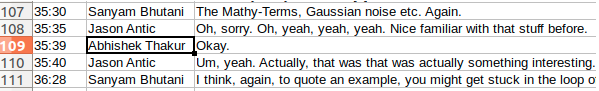
And some of the heroes appeared in podcasts where multiple speakers were present, which is the reason we see significant drop in number of words spoken.

## 3. Analyzing the duration a speaker spoke

### Who spoke for the longest duration (overall)?

In [ ]:
df_temp2 = df.groupby(["Speaker", "episode_id"])["duration"].sum().reset_index().sort_values(by="duration", ascending=False)
df_temp2["duration"] /= 60
df_temp2["derived"] = df_temp2["Speaker"] + " - "+ df_temp2["episode_id"]

##### Distribution of duration

In [ ]:
df_temp2["duration"].hist()

As we can see duration distribution is also long tailed, with most episodes where speakers spoke between 500-1000s. Note that this includes host as a speaker too.

In [ ]:
px.bar(x="derived",y="duration",data_frame=df_temp2[:10],title="10 Speakers with highest speak duration", labels={"derived": "Speaker", "duration": "Speaker Duration(minutes)"})

From Episodes data, we know that **E23 (Andres Torrubia) lasted 2h10mins**. Let's visualize the timeline for the episode. 

In [ ]:
plot_single_episode_timeline("E23", df, df_episodes, max_tick=3600*2+1200)

Also,since we note that the top-10 isn't the same when looking at words or duration, let's try to now visualize top10 at another angle - WPM(words per minute)

## 4. Analyzing WPM(Words per minute)

### Anayzing speaker's WPM(words per minute)

In [ ]:
df_temp3 = df_temp.merge(df_temp2, on="derived")
df_temp3["wpm"] = df_temp3["num_words"] / df_temp3["duration"]
df_temp3 = df_temp3.sort_values("wpm", ascending=False)

##### Distribution of Speaker WPM

In [ ]:
df_temp3["wpm"].hist()

This histogram is a graph shape(distribution) we're used to seeing. Phew!

##### What is average words per minute rate of speaking English?
From google, we can see that the average rate is:
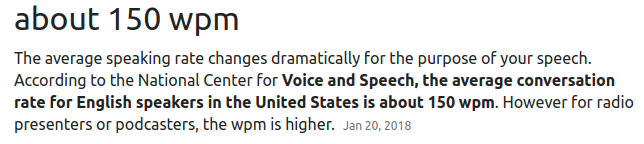

So apart from some outliers, the distribution of wpm correlates with universal known rate. This also indicates that there are less chances of bugs in calculation of words & duration :D 

Let's now see a few episodes where speakers had the highest WPM.

Since the data is grouped by epsidoes, I am also going to filter and consider only non-host speakers and also remove data marked as `Unknown Speaker` in the dataset.

#### Analyzing WPM for other speakers

In [ ]:
px.bar(x="derived",y="wpm",data_frame=df_temp3[(df_temp3["Speaker_x"] != "Sanyam Bhutani") & (df_temp3["Speaker_x"] != "Unknown Speaker")][:20],title="20 speakers with highest words per minute", labels={"derived": "Speaker", "wpm": "WPM(Words per minute)"})

In [ ]:
px.bar(x="derived",y="wpm",data_frame=df_temp3[(df_temp3["Speaker_x"] != "Sanyam Bhutani") & (df_temp3["Speaker_x"] != "Unknown Speaker")][-20:],title="20 speakers with lowest words per minute", labels={"derived": "Speaker", "wpm": "WPM(Words per minute)"})

#### Analyzing WPM for host(Sanyam)

In [ ]:
df_temp3.rename(columns={"episode_id_x": "episode_id"}, inplace=True)
df_temp4 = df_temp3.merge(df_episodes, on="episode_id").sort_values("wpm", ascending=False)
df_temp4["derived"] = df_temp4["heroes"] + " - "  + df_temp4["episode_id"]

In [ ]:
fig = px.bar(x="derived",y="wpm",data_frame=df_temp4[df_temp4["Speaker_x"] == "Sanyam Bhutani"][:10],title="10 highest wpm episodes of Host(Sanyam)", labels={"derived": "Episode", "wpm": "Sanyam's WPM(Words per minute)"})
fig.update_traces(marker_color='#ff7f0e')
fig.show()

In [ ]:
fig = px.bar(x="derived",y="wpm",data_frame=df_temp4[df_temp4["Speaker_x"] == "Sanyam Bhutani"][-10:],title="10 lowest wpm episodes of Host(Sanyam)", labels={"derived": "Episode", "wpm": "Sanyam's WPM(Words per minute)"})
fig.update_traces(marker_color='#ff7f0e')
fig.show()

Let's see the timeline and inspect data for highest wpm episode E49 - Parul Pandey

In [ ]:
plot_single_episode_timeline("E49", df, df_episodes, max_tick=3400)

Upon manual inspection, comparing subtitles with youtube videos, **host wasn't speaking for the duration of 1900-2400s, and the data isn't labelled correctly**. Some of the WPM boost seen here could be coming from Parul's section being mislabelled as Sanyam's section. (Just a guess, didn't verify it, too lazy to manually annotate!)

Overall, it's apretty consistent WPM by host which is usually an indicator of a good podcast host. :) 
However I would still like to hear a possible explanation of WPM difference from **177** to **127** by the host in different episodes.

Let's sidetrack a bit and visualize a couple more of timelines to get an intuitive sense of interviews and conversations. I am printing out couple which I found interesting.

In [ ]:
plot_single_episode_timeline("E63", df, df_episodes, max_tick=4200)

I know for a fact that the host is biased towards fast.ai & kaggle. But could this be a reason for such a lively exchange with Robert Bracco as compared to others? Shouldn't comment without a deeper analysis of text and interactions.

However, in a totally unrelated context, let's see another timeline.

In [ ]:
plot_single_episode_timeline("E36", df, df_episodes, max_tick=4200)

In [ ]:
plot_single_episode_timeline("E35", df, df_episodes, max_tick=4200)

In [ ]:
plot_single_episode_timeline("E1", df, df_episodes, max_tick=4200)

In [ ]:
plot_single_episode_timeline("E74", df, df_episodes, max_tick=4200)

Data doesn't look right for Dmitry Larko E74 as well. Sometimes visualizing through a simple timeline helps to indentify outliers, which then could be followed by deeper look at the data.

## 5. Longest monologue

Following the same pattern, I've skipped our host from the monologue analysis.

In [ ]:
df_temp5 = df.groupby(["Speaker", "episode_id"])["num_words"].max().reset_index().sort_values(by="num_words", ascending=False)
df_temp5["derived"] = df_temp5["Speaker"] + " - "+ df_temp5["episode_id"]

In [ ]:
px.bar(x="derived",y="num_words",data_frame=df_temp5[df_temp5["Speaker"] != "Sanyam Bhutani"][:10],title="10 episodes containing longest monologue by guest speaker", labels={"derived": "Episode", "num_words": "Count of consecutive words spoken"})

We've already established above(by plotting the timeline) that Dmitry data seems to be incorrect. Let's explore E57 a bit

In [ ]:
plot_single_episode_timeline("E57", df, df_episodes, max_tick=4200)

###### Let's find what was Saynam talking about which invoked a long response from Mark.

In [ ]:
rindex = df[(df["episode_id"] == "E57")&(df["num_words"] == 1682)]["relative_index"].values[0]
previous_text = df[(df["episode_id"] == "E57")&(df["relative_index"] == rindex-1)]["Text"].values[0]
current_text = df[(df["episode_id"] == "E57")&(df["relative_index"] == rindex)]["Text"].values[0]

In [ ]:
print("Sanyam's Question:", previous_text)

In [ ]:
fig = px.bar(x="derived",y="num_words",data_frame=df_temp5[df_temp5["Speaker"] == "Sanyam Bhutani"][:10],title="10 episodes containing longest monologue by host", labels={"derived": "Episode", "num_words": "Count of consecutive words spoken by host"})
fig.update_traces(marker_color='#ff7f0e')
fig.show()

It looks like there's some labelling/formatting issue in the data, causing such high numbers. Rest all max values in 500 range points to the introduction part.

## 6. Shortest response by host

Let's get the count of 2-3 length sentences spoken by host as a response and print a few. Note that we're still operating at row level and viewing speaker exchange. This isn't the count of times host speaks a word, but a count of times a short response is given (or as a filler), to another speaker.

In [ ]:
df["text_stripped"] = df["Text"].apply(lambda x: x.strip().replace(".", "").replace(","," "))
df[(df["Speaker"] == "Sanyam Bhutani") &(df["num_words"] < 3)].groupby(["text_stripped"]).count().reset_index().sort_values("Text", ascending=False)[["text_stripped", "Text"]].rename(columns={"text_stripped": "text", "Text": "Times used"})[:15]

### **Okay**.**Yeah**.**Hehehe**.**Makes sense**. :)

## 7. Grouping similar episodes together

There can be multiple approaches of grouping the episodes. I here would like to display a slightly unconventional approach, which is using sentence embeddings.
Let's start by loading a pretrained [Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder/4) which is present in tensorflow_hub

In [ ]:
embedder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In order to get embeddings we simply need to call `embedder([para_or_sentence_to_embed])`. Let's merge all the episode's data in a single row per episode and perform `KMeans` clustering on the embeddings to group data into clusters.

In [ ]:
df_episode_content = df.groupby("episode_id")['Text'].apply(lambda x: ','.join(x)).reset_index()
df_episode_content["embedding"] = None
for idx, row in df_episode_content.iterrows():
    df_episode_content.loc[idx, "embedding"] = list(np.array(embedder([row["Text"]])[0])) # Get embeddings per episode
    
kmeans = KMeans(n_clusters=8, random_state=0).fit(list(df_episode_content["embedding"].values))

df_episode_content["cluster_id"] = kmeans.labels_

df_temp7 = df_episode_content.merge(df_episodes, on="episode_id")
df_temp7 = df_temp7[["episode_id", "episode_name", "cluster_id"]]

Since this is unsupervised clustering algorithm, there's no fixed rule on numbers of cluster and what the clusters actually mean, but I found `n_clusters=8` setting to generate a pretty decent grouping. Let's see a couple of them.

**AutoCluster1: Huggingface, sklearn, spacy, albumentations, DALI augmentations..**

In [ ]:
df_temp7[df_temp7["cluster_id"] == 7]

**AutoCluster2: Freelancing, ML Interview, SharpestMind..**

In [ ]:
df_temp7[df_temp7["cluster_id"] == 4]

**AutoCluster3: Musenet, Audio, Remix, Deoldify..**

In [ ]:
df_temp7[df_temp7["cluster_id"] == 3]

**AutoCluster4: Kaggle..**

In [ ]:
df_temp7[df_temp7["cluster_id"] == 1]

As we can see, even with embeddings generated for the entire transcript together, we are able to form pretty good clusters from it.

## 8. Grouping similar questions together

Using the same sentence encoder and powerful unsupervised Kmeans clustering over it's embeddings, let's now try to group similar questions view a couple of clusters. Another approach (and a more precise approach) would be to use the embeddings and calculate similarities and find closest ones. [Faiss](https://github.com/facebookresearch/faiss) is an excellent library by Facebook research which can take inputs as embeddings(taken from Google's sentence encoder here), and indexes it so that similarity searches can be performed neatly and efficiently.

However for the current task at hand, we will stick to KMeans, as I'd like to demonstrate that this simple clustering algorithm is also able to come up with some gems. 

In [ ]:
df2 = pd.read_csv("subtitles_aggregated.csv")
df2["embedding"] = None
for idx, row in df2.iterrows():
    df2.at[idx, "embedding"] = list(np.array(embedder([row["Text"]])[0]))
    
df2["is_question"] = df2["Text"].apply(lambda x: "?" in x)

# df_questions = df2[(df2["is_question"] == True) & (df2["Speaker"] == "Sanyam Bhutani")]
# kmeans = KMeans(n_clusters=25, random_state=0).fit(list(df_questions["embedding"].values))
# df_questions["cluster_id"] = kmeans.labels_
# df_questions = df_questions.merge(df_episodes, on="episode_id")
# df_temp8 = df_questions[["episode_id", "episode_name", "cluster_id", "Text", "timestamp_relative", "relative_index"]]
df_temp8 = pd.read_csv("../input/ctds-kmeans-clustered/ctds_kmeans_clustered_df.csv") # Kmeans output cache

Let's visualize a few of the interesting clusters and have the Questions and Answers formatted in a single row. To avoid kernel load on UI, I am sampling just 5 rows per cluster.

In [ ]:
df_temp8["answer"] = None
for idx, row in df_temp8.iterrows():
    try:
        df_temp8.at[idx, "answer"] = df2[(df2["episode_id"] == row["episode_id"]) & (df2["relative_index"] == row["relative_index"] + 1)]["Text"].values[0]    
    except:
        pass

**AutoCluster1: Platforms to follow heroes**

In [ ]:
df_temp8[df_temp8["cluster_id"] == 1][["episode_name", "Text", "answer"]].sample(frac=1)[:3].style.set_properties(subset=['Text', "episode_name"], **{'width': '200px'})

**AutoCluster2: Best advice from heroes**

In [ ]:
df_temp8[df_temp8["cluster_id"] == 17][["episode_name", "Text", "answer"]].sample(frac=1)[:3].style.set_properties(subset=['Text', "episode_name"], **{'width': '200px'})

**AutoCluster3: Passions, Interests and how it all started..**

In [ ]:
df_temp8[df_temp8["cluster_id"] == 23][["episode_name", "Text", "answer"]].sample(frac=1)[:3].style.set_properties(subset=['Text', "episode_name"], **{'width': '200px'})

Next steps: 
- Huggingface summarization

## 9. Abstractive Summarization by HuggingFace pipelines

Let's now attempt to summarize all the good advice given by a lot of people and try to view summarizations and see if we can distill the info in a short paragraph.

There are two types of summaries which could be generated:
    - Extractive: Most important sentences/paragraphs/phrases picked from a large content, thus shortening it
    - Abstractive: The cooler one, where we use a pretrained model to generate the `gist` of the content.
    


In [ ]:
from transformers import pipeline
summarizer = pipeline("summarization")

That's it. Just like a simple API with Universal Sentence Encoder, we can use `summarizer(data_to_summarize, max_length=X)` to generate abstractive summaries.

Let's use the same cluster from above (where advice for beginners is asked). 

In [ ]:
df_temp9 = df_temp8[df_temp8["cluster_id"] == 17].copy()
all_answers = " ".join(df_temp9[df_temp9["cluster_id"] == 17]["answer"].values)

Randomly print summary for a single question in the cluster.

In [ ]:
df_temp9["summarized_answer"] = None
ctr = 0
questions, answers, summaries = [], [], []

for idx, row in df_temp9.sample(frac=1).iterrows():
    if len(row["answer"]) < 200:
        continue
    print("*"*10)
    print(row["episode_name"])
    print("*"*10)
    print("Question:")
    print(row["Text"])
    questions.append(row["Text"])
    print("-"*10)
    print("Answer:")
    print(row["answer"])
    answers.append(row["answer"])
    print("-"*10)
    print("Summarized Answer:")
    summary = summarizer(row["answer"], max_length=100, min_length=10, do_sample=False)[0]["summary_text"]
    print(summary)
    summaries.append(summary)
    print("~"*20)
    if ctr == 0:
        break
    ctr+=1

Here are a couple of summaries generated, which I found to be very crisp and precise. Hope you enjoy reading them! 

**ChristOf Henkel - Read.Read.Read. Try not to copy.**
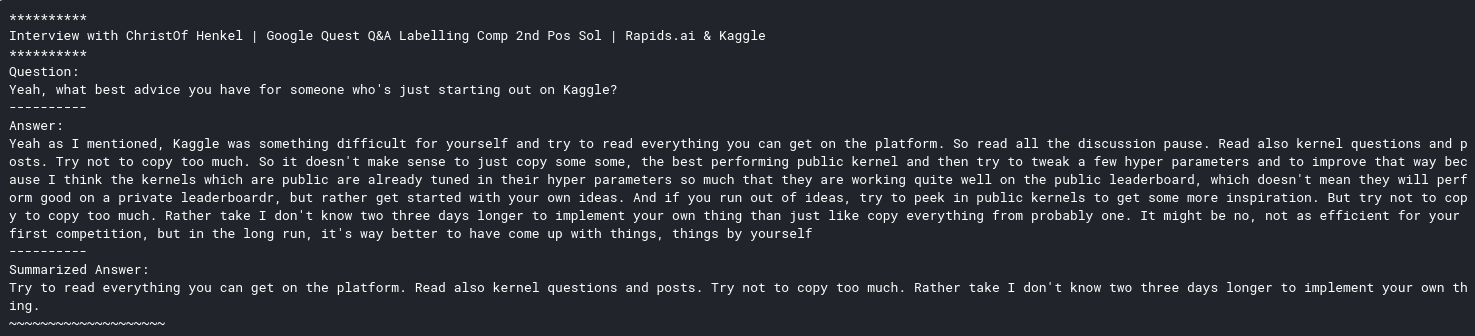

**Anokas - Keep doing it**
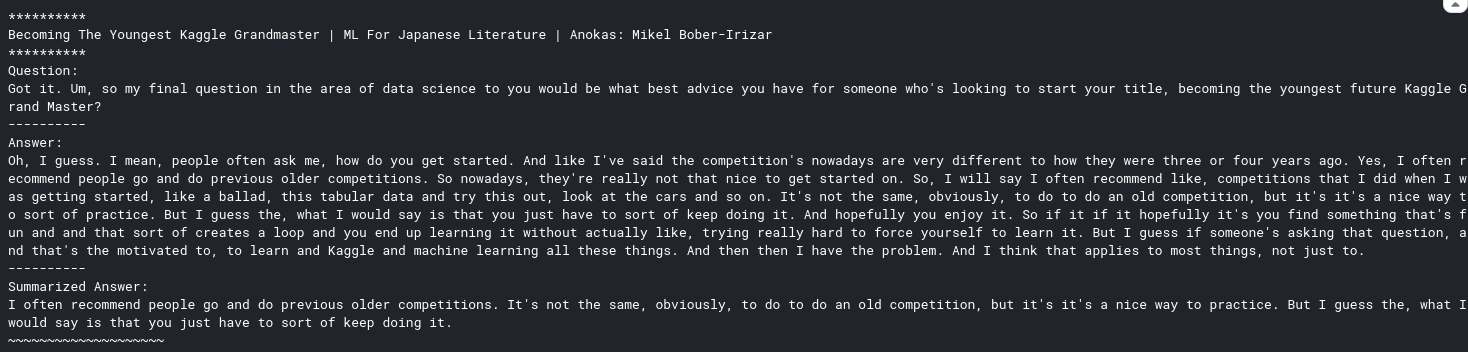

**Robert Bracco - Consistency matters**
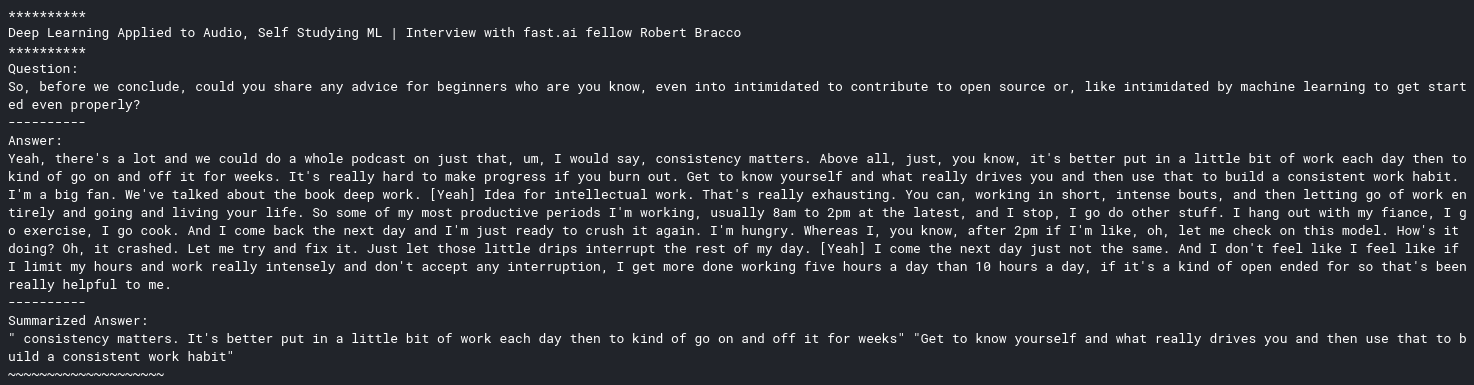

**And finally,advice from Co-founder@HuggingFace, the library which made the summarization pipeline so easy to use**
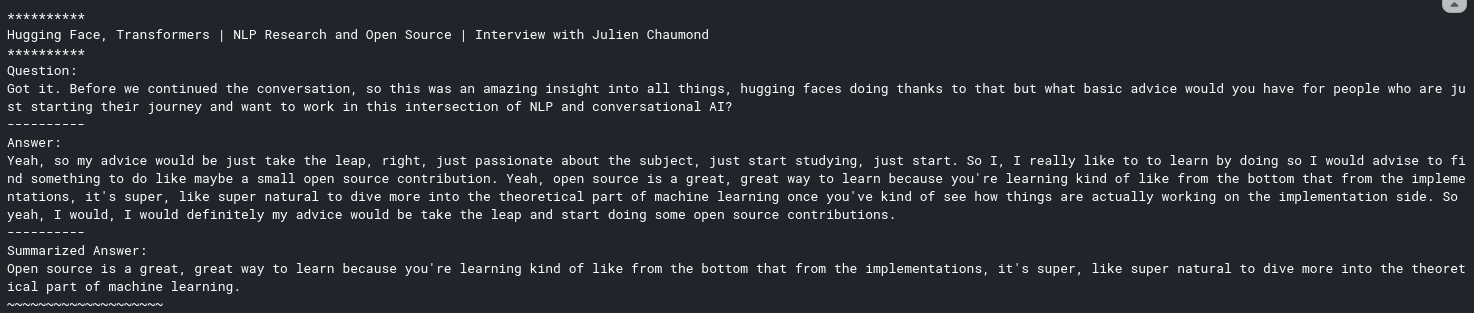

That's it for now. Please let me know in comments if you spot any errors and have suggestions. The output from this kernel can directly be used in further analysis. 

PS: I couldn't find a good library for timeline chart. The closest was plotly's gantt chart, but I couldn't make it work on just the time data(without datetime). So if you have any recommendations to build a similar but interactive timeline chart quickly, please share. 